In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Act Reading, label: proficent_score 

In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
actReading_11_df = pd.read_csv('../dataframes/actReading_11.csv')


In [20]:
actReading_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

PCA

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actReading_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")

Number of components needed: 107
Cumulative explained variance: 0.8008126029661587


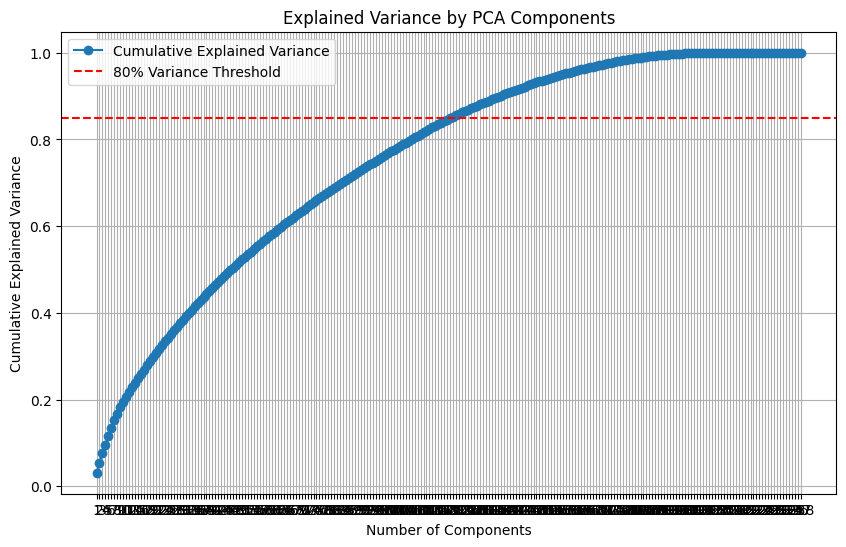

Number of components needed: 107


In [22]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [23]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df


print(pca.components_.shape)
print(actReading_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actReading_11_df.columns]
feature_names = actReading_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [24]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
5                   PC2   course_Physical Sci
6                   PC2   course_English Gr10
7                   PC2    course_Algebra I B
8                   PC2    course_USHis I G10
9                   PC2    course_US His-1877
10                  PC3   course_Eng Gr10 Adv
11                  PC3   course_ChemistryAdv
12                  PC3    course_USHis I Adv
13                  PC3   course_HS US 10 ADV
14                  PC3    course_D&TSafetyEd
15                  PC4   course_Ess II:USHis
16                  PC4   course_Ess: Phy Sci
17                  PC4     course_Eng Ess 10
18                  PC4   course_Alg Esntls B
19                  PC4    course_RdIntrv7-12
20                  PC5   course_E

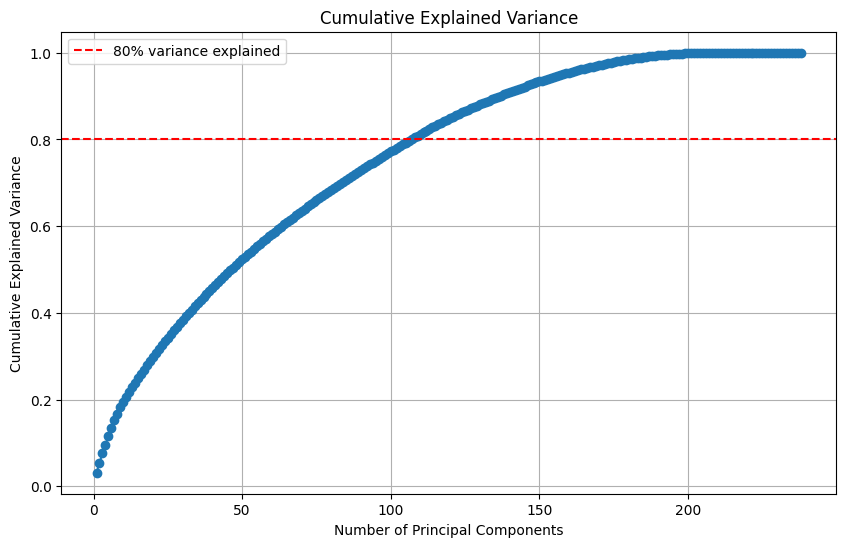

In [25]:
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training on PCA

In [26]:
X_PCA = first_108_pcs_df  # PCA-transformed features
y_PCA = actReading_11_df['proficient_score']
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y_PCA, test_size=0.20,stratify = actReading_11_df['is_proficient'], random_state=123)
print(X_train.shape)

(2062, 108)


In [ ]:
''''
max_depth_values = [5,18,23,32]
n_estimators_value = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values), 'n_estimators' : list(n_estimators_value)}

#Grid Search to find the best hyperparameters 
print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params
'''
#{'max_depth': 23, 'n_estimators': 350}


Running Grid Search
Done


{'max_depth': 23, 'n_estimators': 350}

In [34]:
rf_model_PCA = RandomForestRegressor(max_depth=23, n_estimators=350)
rf_model_PCA.fit(X_train,y_train)

RandomForestRegressor(max_depth=23, n_estimators=350)

Metrics

In [35]:
y_rf_pred= rf_model_PCA.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_rf_pred, squared=False)
rf_r2 = r2_score(y_test, y_rf_pred)

threshold = 1
y_rf_pred_bool = y_rf_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_rf_pred_bool, y_test_bool))

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))        

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.72      0.82       374
        True       0.55      0.87      0.67       142

    accuracy                           0.77       516
   macro avg       0.74      0.80      0.74       516
weighted avg       0.83      0.77      0.78       516

[RF] Root Mean Squared Error: 0.2148655755652137
[RF] R2: 0.5389606989417293


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
micro_f1 = f1_score(y_test_bool, y_rf_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7655038759689923


In [29]:
print(actReading_11_df.dtypes)

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
course_ACTReview.5C        bool
course_AG Communica        bool
course_AIDE-ELEM           bool
course_AIDE-LIB            bool
course_ALG I B ACCE        bool
course_ALIITRIGH/A         bool
course_ARMY LET I          bool
course_ARMY LET II         bool
course_ARMY LET III        bool
course_ARMY LET IV         bool
course_ARMYLETIVACT        bool
course_AcAdv.Baseba        bool
course_AcAdv.Basket        bool
course_AcAdv.CrossC        bool
course_AcAdv.Footb         bool
course_AcAdv.Softba        bool
course_AcAdv.Volley        bool
course_Accounting          bool
course_Adv BTA             bool
course_Advanced Agr        bool
course_Agriscience         bool
course_Alg Esntls B        bool
course_Alg II/Trig         bool
course_AlgEnrichmet        bool
course_AlgII/TrigAC        bool
course_Algebra I           bool
course_A

In [30]:
#changing all bools to ints 0 and 1 for the model
actReading_11_df[actReading_11_df.select_dtypes(include=['bool']).columns] = actReading_11_df.select_dtypes(include=['bool']).astype(int)
actReading_11_df.dtypes

studentId                 int64
is_proficient             int64
proficient_score        float64
course_ACT Review         int64
course_ACT/WK Rev.        int64
course_ACTReview.5C       int64
course_AG Communica       int64
course_AIDE-ELEM          int64
course_AIDE-LIB           int64
course_ALG I B ACCE       int64
course_ALIITRIGH/A        int64
course_ARMY LET I         int64
course_ARMY LET II        int64
course_ARMY LET III       int64
course_ARMY LET IV        int64
course_ARMYLETIVACT       int64
course_AcAdv.Baseba       int64
course_AcAdv.Basket       int64
course_AcAdv.CrossC       int64
course_AcAdv.Footb        int64
course_AcAdv.Softba       int64
course_AcAdv.Volley       int64
course_Accounting         int64
course_Adv BTA            int64
course_Advanced Agr       int64
course_Agriscience        int64
course_Alg Esntls B       int64
course_Alg II/Trig        int64
course_AlgEnrichmet       int64
course_AlgII/TrigAC       int64
course_Algebra I          int64
course_A

In [31]:
#Create Training and Test Data
y = actReading_11_df['proficient_score']
X= actReading_11_df.drop(['proficient_score','is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(X.shape[0]))

X_trainRead,X_testRead, y_trainRead,y_testRead  = train_test_split(X,y, test_size=0.20,stratify = actReading_11_df['is_proficient'],random_state=123)
print(X_trainRead.shape)
print(X_testRead.shape)


Number of examples: 2578
(2062, 238)
(516, 238)


In [32]:
#possible hyperparameters
'''
max_depth_values = [5,18,23,32]
n_estimators_value = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values), 'n_estimators' : list(n_estimators_value)}

#Grid Search to find the best hyperparameters 
print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_trainRead, y_trainRead)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params
#{'max_depth': 32, 'n_estimators': 350}
'''

'\nmax_depth_values = [5,18,23,32]\nn_estimators_value = [100,250,300,350]\nparam_grid = {\'max_depth\' : list(max_depth_values), \'n_estimators\' : list(n_estimators_value)}\n\n#Grid Search to find the best hyperparameters \nprint("Running Grid Search")\nrf_regressor = RandomForestRegressor()\n\n# will have a 3-fold cross validation \nrf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\nrf_grid_search = rf_grid.fit(X_trainRead, y_trainRead)\n\nprint("Done")\nrf_best_params = rf_grid_search.best_params_\n\nrf_best_params\n#{\'max_depth\': 32, \'n_estimators\': 350}\n'

In [33]:
print('Begin Random Forest ')
rf_model = RandomForestRegressor(max_depth=32, n_estimators=350)
rf_model.fit(X_trainRead,y_trainRead)
print('End')

Begin Random Forest 


KeyboardInterrupt: 

In [ ]:
y_rf_predRead = rf_model.predict(X_testRead)
rf_rmse = mean_squared_error(y_testRead, y_rf_predRead, squared=False)
rf_r2 = r2_score(y_testRead, y_rf_predRead)

threshold = 1
y_rf_pred_bool = y_rf_predRead >= threshold
y_test_bool = y_testRead >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_rf_pred_bool, y_test_bool))

print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse))
print('[RF] R2: {0}'.format(rf_r2))        

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.70      0.80       389
        True       0.48      0.87      0.62       127

    accuracy                           0.74       516
   macro avg       0.71      0.78      0.71       516
weighted avg       0.83      0.74      0.76       516

[RF] Root Mean Squared Error: 0.22262439931940667
[RF] R2: 0.5050631529745082


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#looking at the micro score
micro_f1 = f1_score(y_test_bool, y_rf_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7403100775193798


Confusion Matrix:
[[272  17]
 [117 110]]


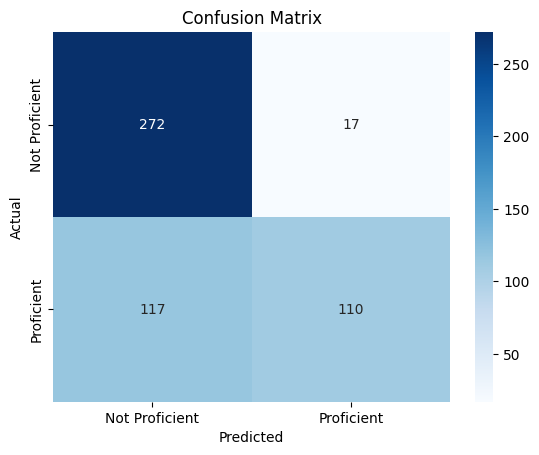

In [ ]:
cm = confusion_matrix(y_test_bool, y_rf_pred_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance 

In [ ]:
importances = rf_model.feature_importances_
feature_names = X_trainRead.columns

# Combine names and importances, and sort
importance_dfRead = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_dfRead= importance_dfRead.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_dfRead)

                  Feature    Importance
58    course_ChemistryAdv  1.534673e-01
76    course_Eng Gr10 Adv  1.288481e-01
84      course_Enviro Sci  3.225114e-02
40    course_BandConcer.5  1.870199e-02
177      course_Spanish 1  1.579828e-02
131   course_LIFE PE 9-12  1.421563e-02
208         course_VarFBI  1.368535e-02
29     course_Algebra I B  1.304773e-02
96    course_Food Nutritn  1.227077e-02
104       course_Geometry  1.182633e-02
158   course_Physical Sci  1.129997e-02
216    course_Vis Arts II  1.087041e-02
142      course_Music App  1.046512e-02
220      course_Vocal I 1  1.034873e-02
183   course_StudyHall912  9.613921e-03
215     course_Vis Arts I  8.976384e-03
186      course_Theatre I  8.740801e-03
128   course_Journalism 1  8.263951e-03
24     course_Alg II/Trig  8.180942e-03
154    course_Per Finance  7.978742e-03
113    course_Health 9-12  7.870531e-03
156    course_Phy Sci Adv  7.700433e-03
209        course_VarFBII  7.587340e-03
105   course_Geometry Adv  7.528466e-03


In [ ]:
importance_dfRead.head(10)

,Feature,Importance
58,course_ChemistryAdv,0.153467
76,course_Eng Gr10 Adv,0.128848
84,course_Enviro Sci,0.032251
40,course_BandConcer.5,0.018702
177,course_Spanish 1,0.015798
131,course_LIFE PE 9-12,0.014216
208,course_VarFBI,0.013685
29,course_Algebra I B,0.013048
96,course_Food Nutritn,0.012271
104,course_Geometry,0.011826


In [ ]:
import shap

c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
explainer = shap.Explainer(rf_model)
shap_test = explainer(X_testRead)
shap_df = pd.DataFrame(shap_test.values, columns=shap_test.feature_names,
  index=X_testRead.index)
# Fetch the importances
shap_df = shap_df.apply(np.abs).mean().sort_values(ascending=False)
print(shap_df)

course_ChemistryAdv     4.575954e-02
course_Eng Gr10 Adv     4.516766e-02
course_Physical Sci     2.285129e-02
course_Algebra I B      1.093585e-02
course_LIFE PE 9-12     1.058997e-02
course_Enviro Sci       9.208311e-03
course_English Gr10     8.462558e-03
course_Spanish 1        7.203525e-03
course_US His-1877      6.226799e-03
course_Mustang Advi     5.506066e-03
course_Alg II/Trig      5.262242e-03
course_StudyHall912     5.109376e-03
course_Health 9-12      5.016532e-03
school_High School C    4.079203e-03
course_Music App        3.641834e-03
course_VisArtI.5C       3.441514e-03
course_VarFBII          3.315392e-03
course_Vis Arts II      3.308390e-03
course_Geometry         3.286950e-03
course_D&TSafetyEd      2.923305e-03
course_BandConcer.5     2.869421e-03
course_Agriscience      2.852447e-03
course_Theatre I        2.819862e-03
course_ALIITRIGH/A      2.759313e-03
course_USHis I Adv      2.751744e-03
course_Food Nutritn     2.614680e-03
course_Phy Sci Adv      2.474582e-03
c

SHAP (SHapley Additive Explanations) interpreting the predictions of machine learning models

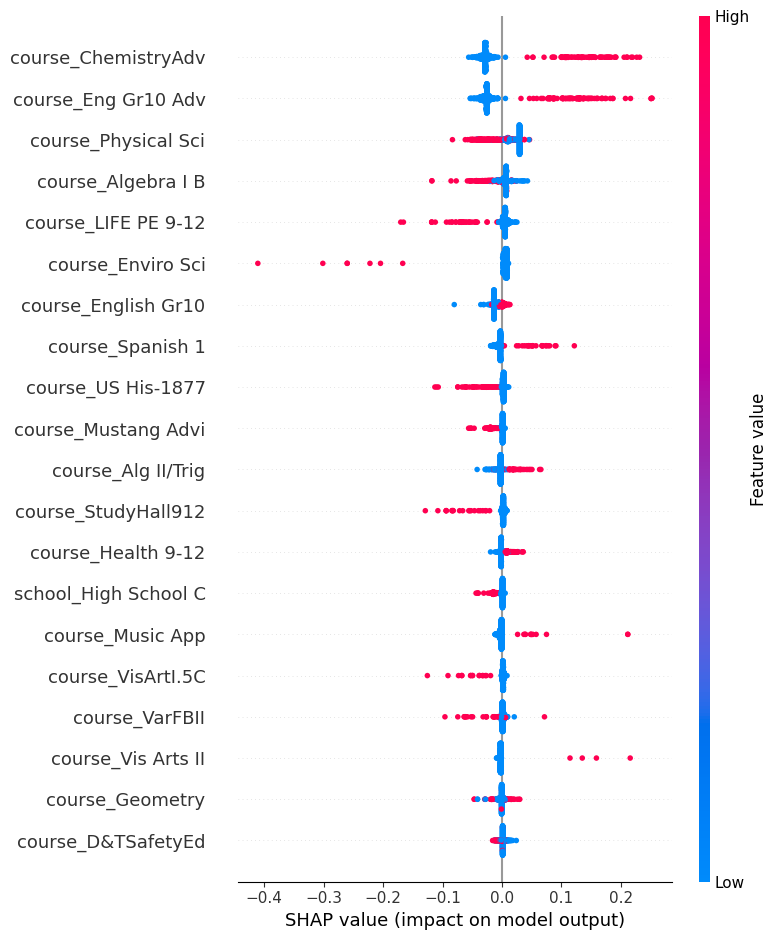

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_testRead)
shap.summary_plot(shap_values,X_testRead)
shap.initjs()  
base_value = explainer.expected_value
shap.force_plot(base_value,shap_values[0], X_testRead.iloc[0])
